In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
sys.path.append("C:/Users/zih028/Documents/GitHub/rl_rebalance")
from src.eval import metrics_from_pnl
from src.MMC.dqn import compute_minimum_variance_weights

In [3]:
def attach_strategy_name(df, strategy_name):
    df = df.copy()
    df["strategy"] = strategy_name
    return df

def build_minvar_targets_for_period(
    returns: pd.DataFrame,
    cov_dict: dict,
) -> pd.DataFrame:
    """
    For each date in returns, compute min-var weights from cov_dict.
    Falls back to equal-weight if no covariance available that day.
    """
    dates = returns.index
    n_assets = returns.shape[1]
    weights_list = []

    for date in dates:
        if date in cov_dict:
            Sigma = cov_dict[date]
            w = compute_minimum_variance_weights(Sigma)
        else:
            w = np.ones(n_assets) / n_assets
        weights_list.append(w)

    targets = pd.DataFrame(weights_list, index=dates, columns=returns.columns)
    return targets

In [4]:
returns = pd.read_parquet("../data/returns.parquet")
prices = pd.read_parquet("../data/prices.parquet")

with open("../data/cov_oas_window252.pkl", "rb") as f:
    cov_dict = pickle.load(f)

train_start = "2010-01-01"
train_end = "2019-12-31"
test_start = "2020-01-01"
test_end = returns.index.max().strftime("%Y-%m-%d")

returns_train = returns.loc[train_start:train_end]
returns_test = returns.loc[test_start:test_end]

targets_train = build_minvar_targets_for_period(returns_train, cov_dict)
targets_test = build_minvar_targets_for_period(returns_test, cov_dict)

df_target_train = targets_train.reset_index().iloc[1:]
df_target_test = targets_test.reset_index().iloc[1:]

In [16]:
dfs_train = []
df_tileq_train = pd.read_csv("../model/tileq_train.csv")
df_dqn_train = pd.read_csv("../model/dqn_train.csv")
df_mmc_train = pd.read_csv("../model/mmc_train.csv")
dfs_train.append(attach_strategy_name(df_tileq_train, "TileQ"))
dfs_train.append(attach_strategy_name(df_dqn_train, "DQN"))
dfs_train.append(attach_strategy_name(df_mmc_train, "MMC"))
dfs_train.append(attach_strategy_name(df_target_train, "Optimal"))
train_results = pd.concat(dfs_train).sort_index()

dfs_test = []
df_tileq_test = pd.read_csv("../model/tileq_test.csv")
df_dqn_test = pd.read_csv("../model/dqn_test.csv")
df_mmc_test = pd.read_csv("../model/mmc_test.csv")
dfs_test.append(attach_strategy_name(df_tileq_test, "TileQ"))
dfs_test.append(attach_strategy_name(df_dqn_test, "DQN"))
dfs_test.append(attach_strategy_name(df_mmc_test, "MMC"))
dfs_test.append(attach_strategy_name(df_target_test, "Optimal"))
test_results = pd.concat(dfs_test).sort_index()

train_results["Date"] = pd.to_datetime(train_results["Date"])
test_results["Date"] = pd.to_datetime(test_results["Date"])

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_weights(all_results, asset_names):
    if not np.issubdtype(all_results["Date"].dtype, np.datetime64):
        all_results = all_results.copy()
        all_results["Date"] = pd.to_datetime(all_results["Date"])

    strategies = sorted(all_results["strategy"].unique())
    n_assets = len(asset_names)
    n_rows, n_cols = 2, 3

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    axes = axes.flatten()

    # Use global unique dates to define sparse tick locations
    all_dates = np.sort(all_results["Date"].unique())
    n_ticks = min(5, len(all_dates))  # at most 5 ticks
    tick_idx = np.linspace(0, len(all_dates) - 1, n_ticks, dtype=int)
    tick_dates = all_dates[tick_idx]

    for i, asset in enumerate(asset_names):
        ax = axes[i]

        for strat in strategies:
            df_strat = all_results[all_results["strategy"] == strat].sort_values("Date")
            ax.plot(df_strat["Date"], df_strat[asset], label=strat, alpha=0.9)

        ax.set_title(asset)
        ax.set_ylabel("Weight")
        ax.grid(alpha=0.3)

        # Use sparse ticks
        ax.set_xticks(tick_dates)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha("right")

    # Hide any unused subplots if asset_names < 6
    for j in range(n_assets, len(axes)):
        axes[j].set_visible(False)

    # Only bottom row gets x-label
    for ax in axes[n_cols:]:
        ax.set_xlabel("Date")

    # One legend at the bottom, horizontal
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc="lower center",
               ncol=len(strategies),
               bbox_to_anchor=(0.5, 0.02))

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig("../figs/covid_weights.png")
    plt.show()

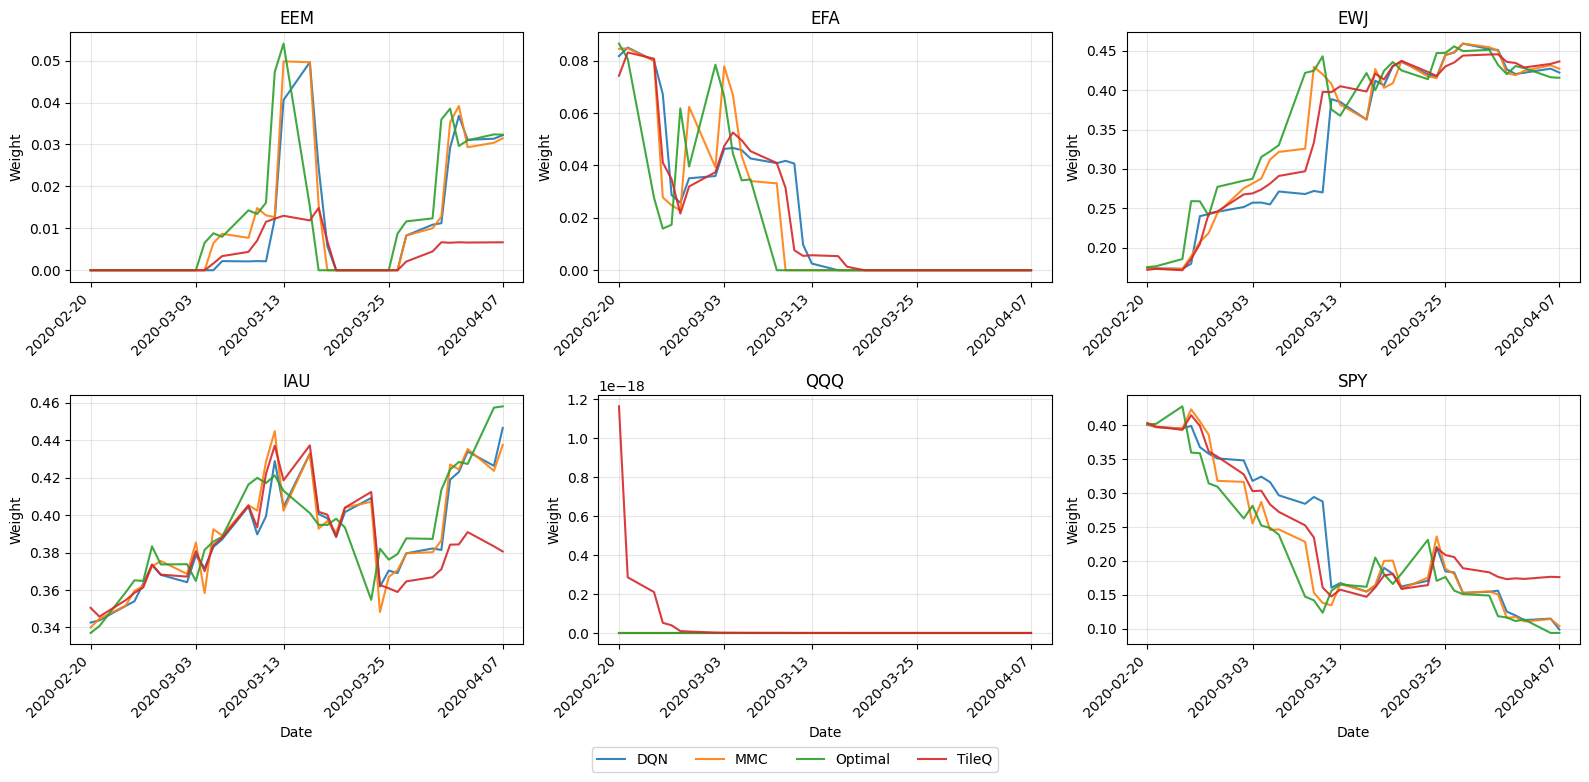

In [42]:
asset_names = ["EEM", "EFA", "EWJ", "IAU", "QQQ", "SPY"]
plot_weights(test_results[(test_results["Date"] > "2020-02-19") & (test_results["Date"] < "2020-04-08")], asset_names)

In [44]:
dfs_train = []
df_tileq_train = pd.read_csv("../model/tileq_train.csv")
df_dqn_train = pd.read_csv("../model/dqn_train.csv")
df_mmc_train = pd.read_csv("../model/mmc_train.csv")
df_monthly_train = pd.read_csv("../model/baseline_monthly_train.csv")
df_band2_train = pd.read_csv("../model/baseline_band2_train.csv")
df_band4_train = pd.read_csv("../model/baseline_band4_train.csv")
dfs_train.append(attach_strategy_name(df_tileq_train, "TileQ"))
dfs_train.append(attach_strategy_name(df_dqn_train, "DQN"))
dfs_train.append(attach_strategy_name(df_mmc_train, "MMC"))
dfs_train.append(attach_strategy_name(df_monthly_train, "Monthly"))
dfs_train.append(attach_strategy_name(df_band2_train, "Band_2%"))
dfs_train.append(attach_strategy_name(df_band4_train, "Band_4%"))
train_results = pd.concat(dfs_train).sort_index()

dfs_test = []
df_tileq_test = pd.read_csv("../model/tileq_test.csv")
df_dqn_test = pd.read_csv("../model/dqn_test.csv")
df_mmc_test = pd.read_csv("../model/mmc_test.csv")
df_monthly_test = pd.read_csv("../model/baseline_monthly_test.csv")
df_band2_test = pd.read_csv("../model/baseline_band2_test.csv")
df_band4_test = pd.read_csv("../model/baseline_band4_test.csv")
dfs_test.append(attach_strategy_name(df_tileq_test, "TileQ"))
dfs_test.append(attach_strategy_name(df_dqn_test, "DQN"))
dfs_test.append(attach_strategy_name(df_mmc_test, "MMC"))
dfs_test.append(attach_strategy_name(df_monthly_test, "Monthly"))
dfs_test.append(attach_strategy_name(df_band2_test, "Band_2%"))
dfs_test.append(attach_strategy_name(df_band4_test, "Band_4%"))
test_results = pd.concat(dfs_test).sort_index()

In [4]:
def plot_weights(all_results, asset_names):
    strategies = all_results["strategy"].unique()

    for strat in strategies:
        df = all_results[all_results["strategy"] == strat]

        plt.figure(figsize=(14, 6))
        for a in asset_names:
            plt.plot(df.index, df[a], label=a, alpha=0.8)
        plt.title(f"Portfolio Weights Over Time — {strat}")
        plt.xlabel("Date")
        plt.ylabel("Weight")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

In [6]:
asset_names = ["EEM", "EFA", "EWJ", "IAU", "QQQ", "SPY"]

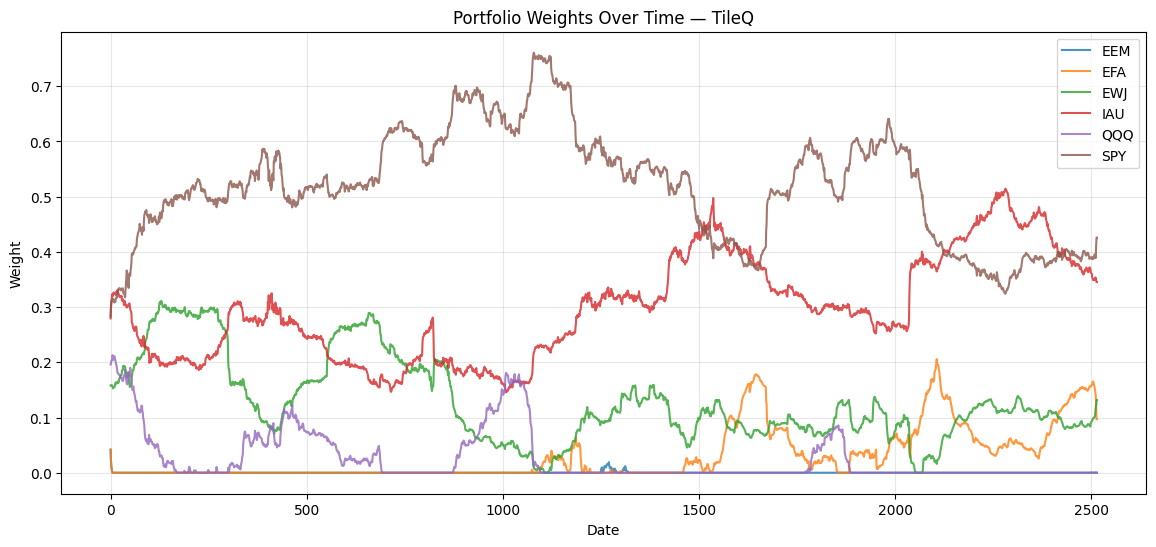

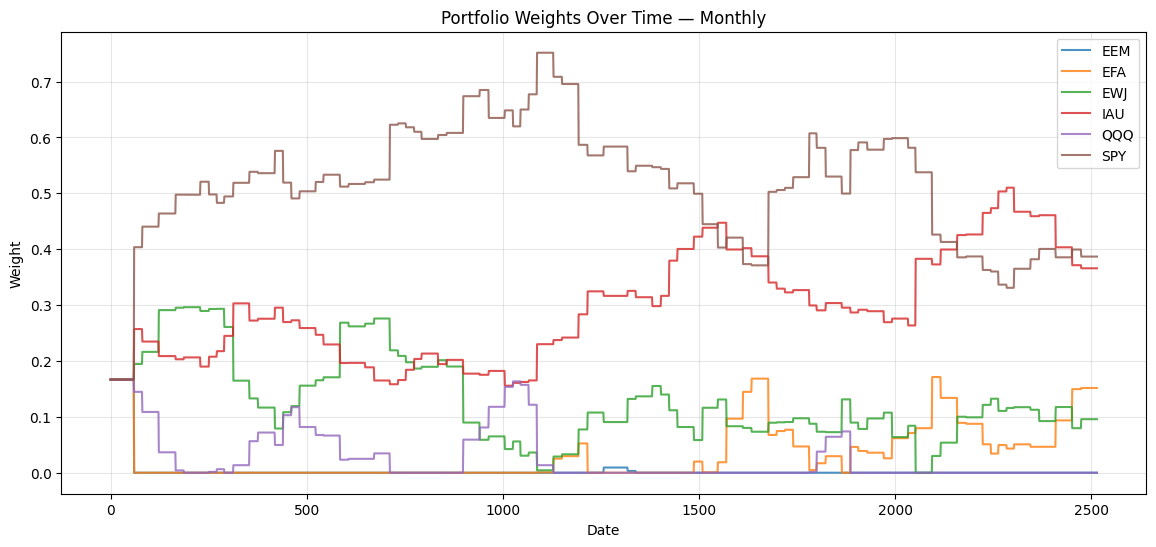

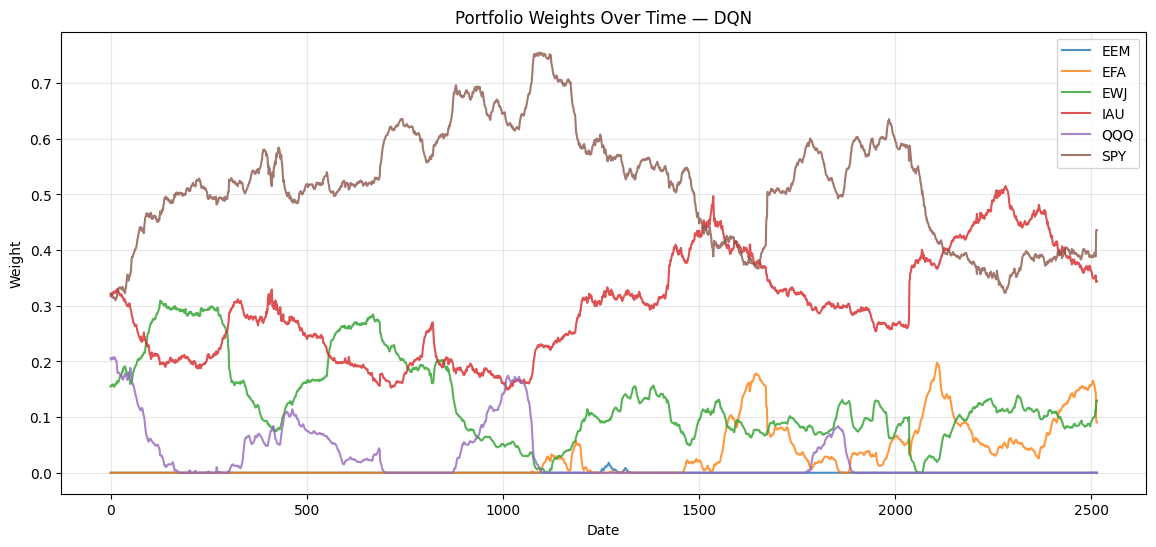

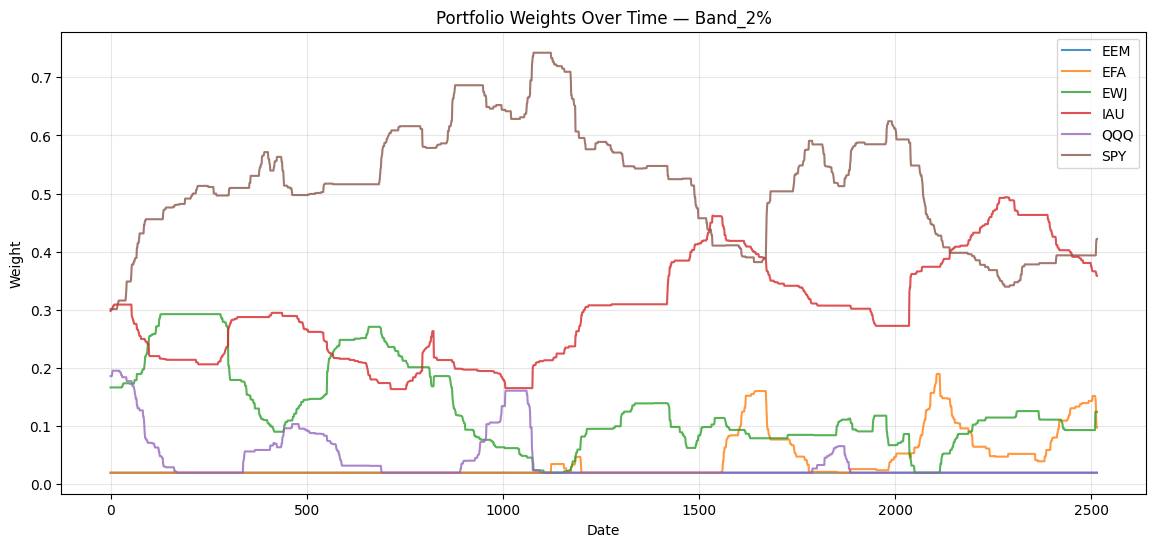

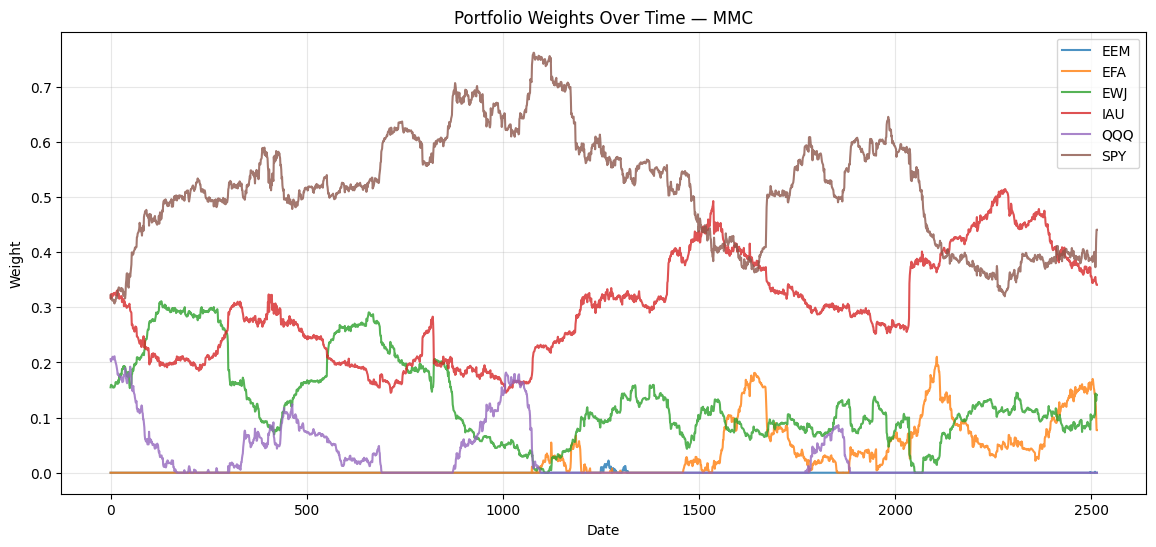

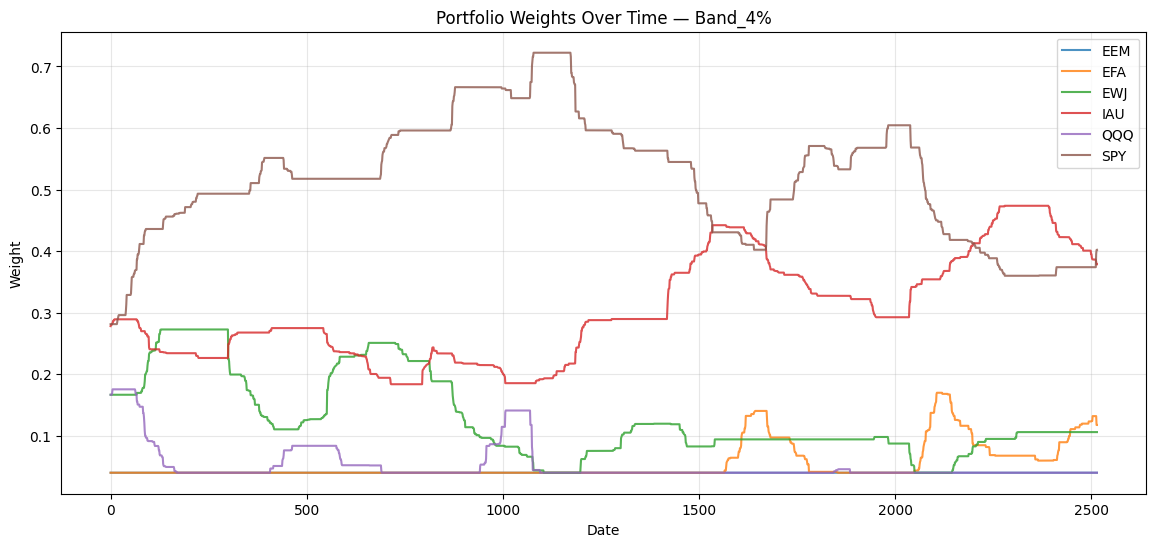

In [ ]:
plot_weights(all_results=train_results, asset_names)

In [13]:
def plot_cumulative_pnl(all_results):
    plt.figure(figsize=(14, 6))

    for strat, df in all_results.groupby("strategy"):
        cumret = (1 + df["pnl"]).cumprod()
        plt.plot(df.index, cumret, label=strat, linewidth=2)

    plt.title("Cumulative Returns Comparison")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

def plot_transaction_costs(all_results):
    plt.figure(figsize=(14, 6))

    for strat, df in all_results.groupby("strategy"):
        plt.plot(df.index, df["tc"].rolling(20).mean(), label=strat)

    plt.title("20-Day Moving Avg Transaction Costs")
    plt.xlabel("Date")
    plt.ylabel("TC (moving avg)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


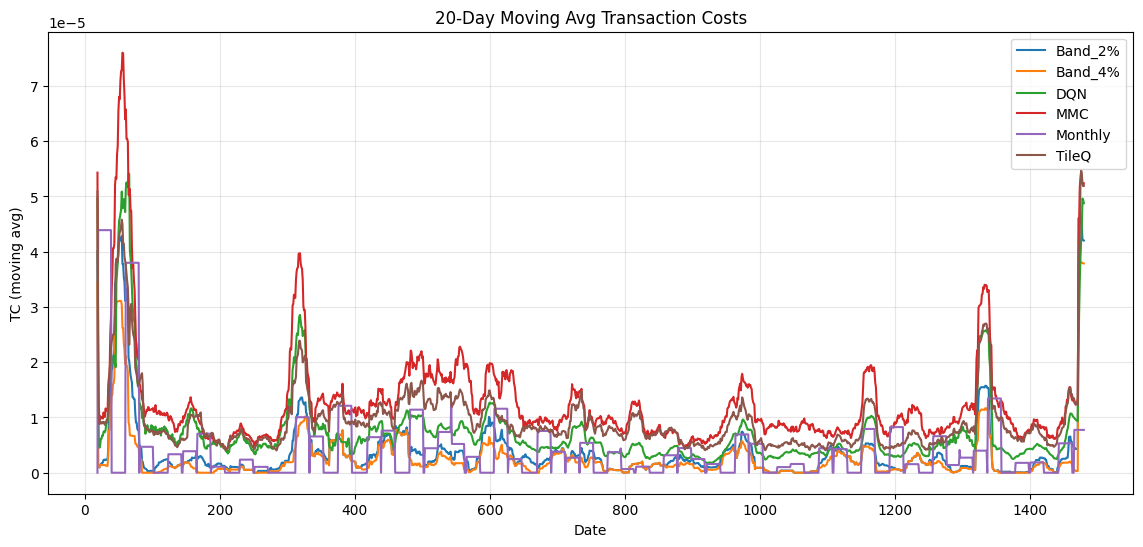

In [14]:
plot_transaction_costs(test_results)

In [17]:
summary_rows = []

for strat, df in test_results.groupby("strategy"):
    metrics = metrics_from_pnl(
        pnl=df["pnl"].values,
        tc_bps=df["tc"].values * 10000
    )
    summary_rows.append((strat, metrics))

summary_df = pd.DataFrame(
    [m for _, m in summary_rows],
    index=[s for s, _ in summary_rows]
)

print(summary_df.round(4))


         ann_ret  ann_vol  sharpe  max_dd  avg_tc_bps
Band_2%   0.1263   0.1496  0.8440 -0.2226      0.0441
Band_4%   0.1303   0.1600  0.8144 -0.2378      0.0327
DQN       0.1166   0.1424  0.8191 -0.2148      0.0830
MMC       0.1182   0.1419  0.8333 -0.2127      0.1358
Monthly   0.1113   0.1482  0.7509 -0.2419      0.0427
TileQ     0.1180   0.1420  0.8310 -0.2129      0.1041


In [45]:
summary_rows = []

for strat, df in train_results.groupby("strategy"):
    metrics = metrics_from_pnl(
        pnl=df["pnl"].values,
        tc_bps=df["tc"].values * 10000
    )
    summary_rows.append((strat, metrics))

summary_df = pd.DataFrame(
    [m for _, m in summary_rows],
    index=[s for s, _ in summary_rows]
)

print(summary_df.round(4))

         ann_ret  ann_vol  sharpe  max_dd  avg_tc_bps
Band_2%   0.0913   0.1178  0.7752 -0.1482      0.0282
Band_4%   0.0971   0.1252  0.7751 -0.1574      0.0190
DQN       0.0865   0.1098  0.7880 -0.1390      0.0597
MMC       0.0848   0.1098  0.7725 -0.1407      0.1201
Monthly   0.0889   0.1113  0.7990 -0.1370      0.0332
TileQ     0.0858   0.1098  0.7811 -0.1382      0.0849
